In [299]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [300]:
def Carlsten(alpha, beta, gamma=0):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

alpha  = 0.33
betas  = np.arange(0.1, 10, 0.01)
gammas = [0., 0.5, 1.]

resTheir = []
for g in gammas:
    resTheir.append(Carlsten(alpha, betas, g))

# MINE NEW

In [301]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E, ell  = sp.symbols('a b x g p E lambda')

In [405]:
# ps should be the same
p0    = p1 / (a*(1-sp.exp(-(1-ell)*b)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
prest = p1*a/(1-2*a)

In [406]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [407]:
p1_sym

a*(2*a*exp(b*(lambda - 1)) - 2*a - exp(b*(lambda - 1)) + 1)/(3*a**2*exp(b*(lambda - 1)) - 3*a**2 - 2*a*exp(b*(lambda - 1)) + 1)

In [408]:
p1_me = (1/(a*(1-sp.exp(-(1-ell)*b))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:1, ell:0.2}), p1_me.evalf(subs={a:0.3, b:1, ell:0.2})

(0.113594788764824, 0.113594788764824)

In [409]:
p1_me

1/(1 + (1 - a)/(1 - 2*a) + 1/(a*(1 - exp(b*(lambda - 1)))))

$$
f_0 = \alpha (\beta+1) e^{-\beta} + \alpha^2 (1-(\beta+1) e^{-\beta}) +\alpha(1-\alpha)(\alpha+\gamma(1-\alpha)) (1-(\beta+1) e^{-\beta})
$$

In [437]:
f0i   = a*(b+1/(1-ell))*sp.exp(-(1-ell)*b) 
f0ii  = a**2*(1/(1-ell) - (b+1/(1-ell))*sp.exp(-(1-ell)*b))
f0iii = a*(1-a)*(a+g*(1-a))*(1/(1-ell) - (b+1/(1-ell))*sp.exp(-(1-ell)*b))
f0i

a*(b + 1/(1 - lambda))*exp(b*(lambda - 1))

In [438]:
f0 = f0i + f0ii + f0iii
f0

a**2*(-(b + 1/(1 - lambda))*exp(b*(lambda - 1)) + 1/(1 - lambda)) + a*(1 - a)*(a + g*(1 - a))*(-(b + 1/(1 - lambda))*exp(b*(lambda - 1)) + 1/(1 - lambda)) + a*(b + 1/(1 - lambda))*exp(b*(lambda - 1))

In [439]:
# REAL
f1 = (1/(1-ell))*(a + 2*a*(1-a))
f1

(2*a*(1 - a) + a)/(1 - lambda)

In [440]:
full = p0*f0 + p1*f1 + (1/(1-ell))*p1*a*a*(3-2*a)/(1-2*a)
final = sp.simplify(full.evalf(subs={p1:p1_me}))
finalLambda = sp.lambdify((a, b, g, ell), final, )
finalLambda

<function _lambdifygenerated(a, b, g, lambda_)>

In [441]:
a_ = 0.45
b_ = 100.3
g_ = 1.

In [442]:
subs = {a:a_, b:b_, g:g_}
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)
ell_ = sp.nsolve(eq1, ell, 0.1)
ell_

0.346815286624204

In [445]:
finalLambda(a_, b_, g_, float(ell_)),  1/(1-ell_)*Carlsten(a_, b_, g_), \
finalLambda(a_, b_, g_, float(ell_)) - 1/(1-ell_)*Carlsten(a_, b_, g_)

(1.0878108239882982, 1.08781082398830, -2.22044604925031e-16)

In [74]:
alpha  = 0.33
betas_NEW  = np.arange(0.1, 10, 0.2)
gammas = [0., 0.5, 1.]

resNEW = []
for g_ in gammas:
    attack = finalLambda(alpha, betas_NEW, g_, 0.)
    resNEW.append(attack)

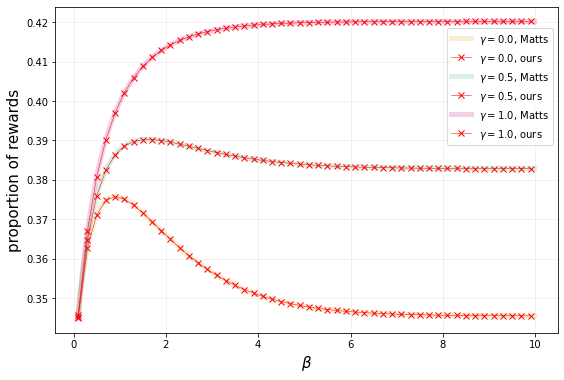

In [75]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, Matts'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas_NEW, resNEW[i], color='red', alpha=1, marker='x',
            label='$\gamma={:0.1f}$, ours'.format(gammas[i]),
            linestyle='-', linewidth=0.5)

    

ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

# NEW RATE 1/(1-lambda)

In [474]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, E, ell  = sp.symbols('a b x g p E lambda')

In [481]:
# ps should be the same
p0    = p1 / (a*(1-sp.exp(-b/(1-ell))))
p0p   = p1 * (1-a)
p0pp  = p1 * a
prest = p1*a/(1-2*a)

In [482]:
p0

p_1/(a*(1 - exp(-b/(1 - lambda))))

In [476]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [449]:
p1_sym

a*(2*a*exp(b/(lambda - 1)) - 2*a - exp(b/(lambda - 1)) + 1)/(-3*a**2 + a*(3*a - 2)*exp(b/(lambda - 1)) + 1)

In [477]:
p1_me = (1/(a*(1-sp.exp(-b/(1-ell)))) + 1+ (1-a)/(1-2*a))**(-1)
p1_sym.evalf(subs={a:0.3, b:1, ell:0.2}), p1_me.evalf(subs={a:0.3, b:1, ell:0.2})

(0.134737530842340, 0.134737530842340)

In [478]:
p1_me

1/(1 + (1 - a)/(1 - 2*a) + 1/(a*(1 - exp(-b/(1 - lambda)))))

$$
f_0 = \alpha (\beta+1) e^{-\beta} + \alpha^2 (1-(\beta+1) e^{-\beta}) +\alpha(1-\alpha)(\alpha+\gamma(1-\alpha)) (1-(\beta+1) e^{-\beta})
$$

In [543]:
f0i   = a*(b+1-ell)*sp.exp(-b/(1-ell)) 
f0ii  = a**2*(1-ell - (b+1-ell)*sp.exp(-b/(1-ell)))
f0iii = a*(1-a)*(a+g*(1-a))*(1-ell - (b+1-ell)*sp.exp(-b/(1-ell)))
f0iii

a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1)

In [453]:
f0 = f0i + f0ii + f0iii
f0

a**2*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1) + a*(1 - a)*(a + g*(1 - a))*(-lambda - (b - lambda + 1)*exp(-b/(1 - lambda)) + 1) + a*(b - lambda + 1)*exp(-b/(1 - lambda))

In [454]:
# REAL
f1 = (1-ell)*(a + 2*a*(1-a))
f1

(1 - lambda)*(2*a*(1 - a) + a)

In [455]:
full = p0*f0 + p1*f1 + (1-ell)*p1*a*a*(3-2*a)/(1-2*a)
final = sp.simplify(full.evalf(subs={p1:p1_me}))
finalLambda = sp.lambdify((a, b, g, ell), final, )
finalLambda

<function _lambdifygenerated(a, b, g, lambda_)>

In [547]:
a_ = 0.1
b_ = 2.
g_ = 1.

In [545]:
subs = {a:a_, b:b_, g:g_}
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)
ell_ = sp.nsolve(eq1, ell, 0.1)
ell_

0.0826233579870832

In [546]:
finalLambda(a_, float(b_*(1-ell_)), g_, float(ell_))/(1-ell_),  Carlsten(a_, b_, g_), \
finalLambda(a_, float(b_*(1-ell_)), g_, float(ell_))/(1-ell_) - Carlsten(a_, b_, g_)

(0.108325499509641, 0.10832549950964139, 2.77555756156289e-17)

In [74]:
alpha  = 0.33
betas_NEW  = np.arange(0.1, 10, 0.2)
gammas = [0., 0.5, 1.]

resNEW = []
for g_ in gammas:
    attack = finalLambda(alpha, betas_NEW, g_, 0.)
    resNEW.append(attack)

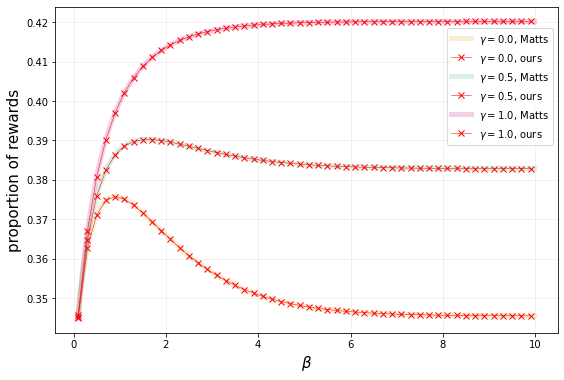

In [75]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['goldenrod', 'mediumseagreen', 'mediumvioletred']
for i in [0, 1, 2]:
    ax.plot(betas, resTheir[i], color=colors[i], alpha=0.2,
            label='$\gamma={:0.1f}$, Matts'.format(gammas[i]), 
            linestyle='-', linewidth=5)
    ax.plot(betas_NEW, resNEW[i], color='red', alpha=1, marker='x',
            label='$\gamma={:0.1f}$, ours'.format(gammas[i]),
            linestyle='-', linewidth=0.5)

    

ax.set_xlabel(r'$\beta$', size=15)
ax.set_ylabel(r'proportion of rewards', size=15)
ax.grid(alpha=0.2)
ax.legend(bbox_to_anchor=(1,.95))

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [421]:
# RANDOM

In [422]:
p1_me

1/(1 + (1 - a)/(1 - 2*a) + 1/(a*(1 - exp(b*(lambda - 1)))))

$$
f_0 = \alpha (\beta+1) e^{-\beta} + \alpha^2 (1-(\beta+1) e^{-\beta}) +\alpha(1-\alpha)(\alpha+\gamma(1-\alpha)) (1-(\beta+1) e^{-\beta})
$$

In [429]:
f0i   = a*(b+1/(1-ell))
f0ii  = a**2*(1/(1-ell) - (b*sp.exp(-(1-ell)*b)/(1-sp.exp(-(1-ell)*b))))
f0iii = a*(1-a)*(a+g*(1-a))*(1/(1-ell) - (b*sp.exp(-(1-ell)*b)/(1-sp.exp(-(1-ell)*b))))
f0i

a*(b + 1/(1 - lambda))

In [430]:
f0 = f0i + f0ii + f0iii
f0

a**2*(-b*exp(b*(lambda - 1))/(1 - exp(b*(lambda - 1))) + 1/(1 - lambda)) + a*(1 - a)*(a + g*(1 - a))*(-b*exp(b*(lambda - 1))/(1 - exp(b*(lambda - 1))) + 1/(1 - lambda)) + a*(b + 1/(1 - lambda))

In [431]:
# REAL
f1 = (1/(1-ell))*(a + 2*a*(1-a))
f1

(2*a*(1 - a) + a)/(1 - lambda)

In [432]:
full = p0*f0 + p1*f1 + (1/(1-ell))*p1*a*a*(3-2*a)/(1-2*a)
final = sp.simplify(full.evalf(subs={p1:p1_me}))
finalLambda = sp.lambdify((a, b, g, ell), final, )
finalLambda

<function _lambdifygenerated(a, b, g, lambda_)>

In [433]:
a_ = 0.45
b_ = 100.3
g_ = 1.

In [434]:
subs = {a:a_, b:b_, g:g_}
o_rest = p1*a*(1-a)/(1-2*a)
orphan_full = p0p + o_rest

eq1 = sp.Eq(orphan_full.subs({p1:p1_sym}).subs(subs), ell)
ell_ = sp.nsolve(eq1, ell, 0.1)
ell_

0.346815286624204

In [436]:
finalLambda(a_, b_, g_, float(ell_)),  1/(1-ell_)*Carlsten(a_, b_, g_), \
finalLambda(a_, b_, g_, float(ell_)) - 1/(1-ell_)*Carlsten(a_, b_, g_)

(12.762698015881636, 1.08781082398830, 11.6748871918933)

In [ ]:
`